In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# base_path = '/media/anant/data/amazon_from_space/'
base_path = '/media/avemuri/DEV/Data/amazon_from_space/'

In [3]:
train_df = pd.read_csv(base_path+'train_v2.csv')
train_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [4]:
# Print all unique tags
from itertools import chain
labels_list = list(chain.from_iterable([tags.split(" ") for tags in train_df['tags'].values]))
labels_set = set(labels_list)
print("There is {} unique labels including {}".format(len(labels_set), labels_set))

There is 17 unique labels including {'cloudy', 'haze', 'selective_logging', 'partly_cloudy', 'conventional_mine', 'agriculture', 'primary', 'blow_down', 'cultivation', 'bare_ground', 'water', 'habitation', 'clear', 'road', 'blooming', 'artisinal_mine', 'slash_burn'}


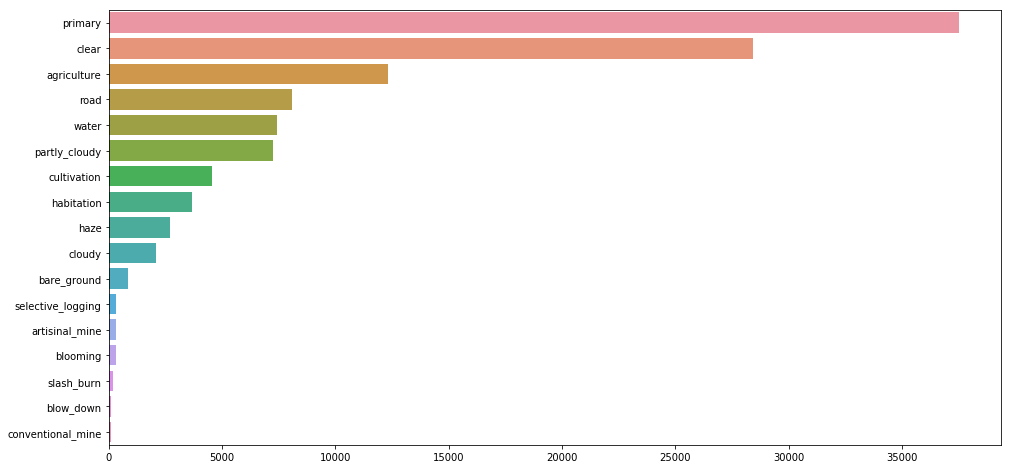

In [5]:
labels_s = pd.Series(labels_list).value_counts() # To sort them by count
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=labels_s, y=labels_s.index, orient='h')

In [6]:
weights = labels_s.values/labels_s.values.sum()
print(weights, labels_s.index)

[0.32261477 0.24450885 0.10590997 0.06941124 0.06373519 0.06244517
 0.03910456 0.03147629 0.02319441 0.01796557 0.00741327 0.00292403
 0.00291543 0.00285523 0.00179742 0.00086861 0.00086001] Index(['primary', 'clear', 'agriculture', 'road', 'water', 'partly_cloudy',
       'cultivation', 'habitation', 'haze', 'cloudy', 'bare_ground',
       'selective_logging', 'artisinal_mine', 'blooming', 'slash_burn',
       'blow_down', 'conventional_mine'],
      dtype='object')


In [7]:
index = ['conventional_mine', 'road', 'habitation', 'primary', 'cloudy', 'cultivation', 'partly_cloudy', 'artisinal_mine', 'selective_logging', 'blooming', 'agriculture', 'water', 'bare_ground', 'blow_down', 'slash_burn', 'clear', 'haze']
labels_s.reindex(index)
weights = labels_s.values/labels_s.values.sum()
print(weights, labels_s.index)

conventional_mine      100
road                  8071
habitation            3660
primary              37513
cloudy                2089
cultivation           4547
partly_cloudy         7261
artisinal_mine         339
selective_logging      340
blooming               332
agriculture          12315
water                 7411
bare_ground            862
blow_down              101
slash_burn             209
clear                28431
haze                  2697
dtype: int64

[0.32261477 0.24450885 0.10590997 0.06941124 0.06373519 0.06244517
 0.03910456 0.03147629 0.02319441 0.01796557 0.00741327 0.00292403
 0.00291543 0.00285523 0.00179742 0.00086861 0.00086001] Index(['primary', 'clear', 'agriculture', 'road', 'water', 'partly_cloudy',
       'cultivation', 'habitation', 'haze', 'cloudy', 'bare_ground',
       'selective_logging', 'artisinal_mine', 'blooming', 'slash_burn',
       'blow_down', 'conventional_mine'],
      dtype='object')


In [8]:
print(labels_s)

primary              37513
clear                28431
agriculture          12315
road                  8071
water                 7411
partly_cloudy         7261
cultivation           4547
habitation            3660
haze                  2697
cloudy                2089
bare_ground            862
selective_logging      340
artisinal_mine         339
blooming               332
slash_burn             209
blow_down              101
conventional_mine      100
dtype: int64


In [9]:
reindexed = labels_s.reindex(index)

In [10]:
print(reindexed)
weights = 10*reindexed.values/reindexed.values.sum()
print(weights)

conventional_mine      100
road                  8071
habitation            3660
primary              37513
cloudy                2089
cultivation           4547
partly_cloudy         7261
artisinal_mine         339
selective_logging      340
blooming               332
agriculture          12315
water                 7411
bare_ground            862
blow_down              101
slash_burn             209
clear                28431
haze                  2697
dtype: int64
[0.00860008 0.69411239 0.3147629  3.22614768 0.17965565 0.3910456
 0.62445174 0.02915427 0.02924027 0.02855226 1.05909974 0.63735186
 0.07413268 0.00868608 0.01797417 2.44508849 0.23194413]


In [11]:
from tqdm import tqdm, tqdm_notebook
import cv2

import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.models as models

from ignite.engine import create_super


from sklearn.metrics import accuracy_score, fbeta_score

In [12]:
X = []
y = []


df_train = pd.read_csv(base_path+'train_v2.csv')

flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))

label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

for f, tags in tqdm(df_train.values, miniters=1000):
    img = cv2.imread(base_path+'train-jpg/'+'{}.jpg'.format(f))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    X.append(cv2.resize(img, (32, 32)))
    y.append(targets)
    
y = np.array(y, np.uint8)
X = np.array(X, np.float16) / 255.

print(X.shape)
print(y.shape)

100%|██████████| 40479/40479 [00:42<00:00, 955.77it/s]


(40479, 32, 32, 3)
(40479, 17)


In [13]:
X = np.moveaxis(X, [0,1,2,3], [0,2,3,1])
print(X.shape)

(40479, 3, 32, 32)


In [20]:
SPLIT = 0.2
# IMG_SIZE = 32
BATCH_SIZE = 256
SHUFFLE = True
dataset_size = len(X)
indices = list(range(dataset_size))
split = int(np.floor(SPLIT * dataset_size))

np.random.seed(42)
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]
x_train, x_valid, y_train, y_valid = X[train_indices], X[val_indices], y[train_indices], y[val_indices]
print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)

(32384, 3, 32, 32) (32384, 17) (8095, 3, 32, 32) (8095, 17)


In [21]:
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_train).float(), torch.from_numpy(y_train).float())
valid_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_valid).float(), torch.from_numpy(y_valid).float())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=8)
validation_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, num_workers=8)

In [22]:
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break

torch.Size([256, 3, 32, 32]) torch.Size([256, 17])


In [45]:
class BaseNet(nn.Module):
    def __init__(self):
        super(BaseNet, self).__init__()
        self.conv11 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv12 = nn.Conv2d(32, 32, kernel_size=3)
        self.conv13 = nn.Conv2d(32, 32, kernel_size=3)
        
        self.conv21 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv22 = nn.Conv2d(64, 64, kernel_size=3)
        self.conv23 = nn.Conv2d(64, 64, kernel_size=3)
        
        self.conv2_drop = nn.Dropout2d()
        
        self.fc1 = nn.Linear(576, 256)
        self.fc2 = nn.Linear(256, 17)

    def forward(self, x):
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = self.conv2_drop(F.max_pool2d(F.relu(self.conv13(x)), (2,2)))
        
        x = F.relu(self.conv21(x))
        x = F.relu(self.conv22(x))
        x = self.conv2_drop(F.max_pool2d(F.relu(self.conv23(x)), (2,2)))
                
        x = x.view(x.size(0), -1) # Flatten layer
                
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        
        return torch.sigmoid(x)

In [46]:
def train(train_loader, epochs, GPU, print_after=-1, model=None):
    
    if model is None:
        model = BaseNet()
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    #scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1, 
    #                                              step_size_up=len(train_loader)//4, cycle_momentum=False)

    if torch.cuda.is_available():
        model = model.to(torch.device(GPU))
        
    if print_after < 0:
        print_after = len(train_loader)//2
        
    loss_list = []
    eval_loss_list = []
    accuracy_list = []
        
    for epoch in range(epochs):
        for iteration, (images, labels) in enumerate(train_loader):

            model = model.train()
            if torch.cuda.is_available():
                images = images.to(torch.device(GPU))
                labels = labels.to(torch.device(GPU))
                
            optimizer.zero_grad()
            pred = model(images)
            loss = F.binary_cross_entropy(pred, labels)
            loss.backward()
            optimizer.step()
            #scheduler.step()
            loss_list.append(loss.detach().cpu().data)
            if iteration % print_after == 0:
                
                eval_loss = 0
                true_labels = []
                predictions = []
                model = model.eval()
                for eval_iteration, (X, y) in enumerate(validation_loader):
                    if torch.cuda.is_available():
                        X = X.to(torch.device(GPU))
                        y = y.to(torch.device(GPU))

                    y_pred = model(X)

                    if torch.cuda.is_available():
                        eval_loss += F.binary_cross_entropy(y_pred, y).cpu().detach().numpy()
                        true_labels.extend(y.detach().cpu().numpy().tolist())
                        predictions.extend(y_pred.detach().cpu().numpy().tolist())
                    else:
                        eval_loss += F.binary_cross_entropy(y_pred, y).detach().numpy()
                        true_labels.extend(y.detach().numpy().tolist())
                        predictions.extend(torch.sigmoid(y_pred.detach()).numpy().tolist())
                        
                
                true_labels = np.vstack(true_labels)
                predictions = np.vstack(predictions)
#                 print(predictions)
                
#                 score = fbeta_score(true_labels, predictions>0.5, beta=2, average='samples')
                accuracy = accuracy_score(true_labels, predictions>0.5)
    
                eval_loss_list.append(eval_loss/len(train_loader))
                accuracy_list.append(accuracy)
    
    
                
                
                
                print("EPOCH: {0}: ITERATION: {1} / {2} : LOSS: {3}     EVALUATION: [{4}, {5}]".format(epoch, iteration, 
                                                                                                       len(train_loader),
                                                                                                       np.round(loss_list[-1], 3), 
                                                                                                       np.round(eval_loss_list[-1], 3), 
                                                                                                       np.round(accuracy_list[-1], 3)))
                
    return model, loss_list, eval_loss_list, accuracy_list
                
                
                

In [47]:
model, loss_list, eval_loss_list, accuracy_list = train(train_loader, 50, 'cuda:0', len(train_loader)//1)

EPOCH: 0: ITERATION: 0 / 127 : LOSS: 0.6869999766349792     EVALUATION: [0.172, 0.0]
EPOCH: 1: ITERATION: 0 / 127 : LOSS: 0.25     EVALUATION: [0.063, 0.343]
EPOCH: 2: ITERATION: 0 / 127 : LOSS: 0.23999999463558197     EVALUATION: [0.059, 0.342]
EPOCH: 3: ITERATION: 0 / 127 : LOSS: 0.22499999403953552     EVALUATION: [0.059, 0.356]
EPOCH: 4: ITERATION: 0 / 127 : LOSS: 0.2240000069141388     EVALUATION: [0.057, 0.313]
EPOCH: 5: ITERATION: 0 / 127 : LOSS: 0.2150000035762787     EVALUATION: [0.054, 0.356]
EPOCH: 6: ITERATION: 0 / 127 : LOSS: 0.2029999941587448     EVALUATION: [0.051, 0.385]
EPOCH: 7: ITERATION: 0 / 127 : LOSS: 0.19900000095367432     EVALUATION: [0.051, 0.411]
EPOCH: 8: ITERATION: 0 / 127 : LOSS: 0.18799999356269836     EVALUATION: [0.047, 0.42]
EPOCH: 9: ITERATION: 0 / 127 : LOSS: 0.18400000035762787     EVALUATION: [0.048, 0.429]
EPOCH: 10: ITERATION: 0 / 127 : LOSS: 0.17800000309944153     EVALUATION: [0.045, 0.46]
EPOCH: 11: ITERATION: 0 / 127 : LOSS: 0.18000000715255

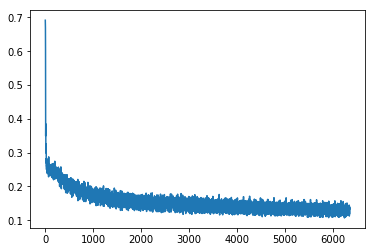

In [43]:
_ = plt.plot(loss_list)

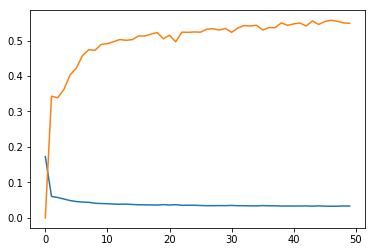

In [44]:
_ = plt.plot(eval_loss_list)
_ = plt.plot(accuracy_list)

In [48]:
model, loss_list, eval_loss_list, accuracy_list = train(train_loader, 40, 'cuda:0', len(train_loader)//1, model)

EPOCH: 0: ITERATION: 0 / 127 : LOSS: 0.1420000046491623     EVALUATION: [0.036, 0.522]
EPOCH: 1: ITERATION: 0 / 127 : LOSS: 0.12999999523162842     EVALUATION: [0.036, 0.516]
EPOCH: 2: ITERATION: 0 / 127 : LOSS: 0.13300000131130219     EVALUATION: [0.035, 0.52]
EPOCH: 3: ITERATION: 0 / 127 : LOSS: 0.13099999725818634     EVALUATION: [0.036, 0.523]
EPOCH: 4: ITERATION: 0 / 127 : LOSS: 0.13099999725818634     EVALUATION: [0.036, 0.528]
EPOCH: 5: ITERATION: 0 / 127 : LOSS: 0.13500000536441803     EVALUATION: [0.035, 0.527]
EPOCH: 6: ITERATION: 0 / 127 : LOSS: 0.12800000607967377     EVALUATION: [0.035, 0.523]
EPOCH: 7: ITERATION: 0 / 127 : LOSS: 0.1340000033378601     EVALUATION: [0.035, 0.526]
EPOCH: 8: ITERATION: 0 / 127 : LOSS: 0.1469999998807907     EVALUATION: [0.035, 0.52]
EPOCH: 9: ITERATION: 0 / 127 : LOSS: 0.12700000405311584     EVALUATION: [0.035, 0.529]
EPOCH: 10: ITERATION: 0 / 127 : LOSS: 0.1289999932050705     EVALUATION: [0.035, 0.529]
EPOCH: 11: ITERATION: 0 / 127 : LOSS:

KeyboardInterrupt: 

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, fbeta_score
from tqdm import tqdm_notebook, tqdm



In [13]:
image_list = [f for f in glob.glob(base_path+'train-jpg/*.jpg')]
print(len(image_list))

40479


In [14]:
class AmazonDataset(Dataset):
    def __init__(self, base_folder, csv_file, folder_name, transform=None):
        self.csv_file = csv_file
        self.labels_df = pd.read_csv(base_path+csv_file)
        self.base_folder = base_folder
        self.image_list = [f for f in glob.glob(base_path+folder_name+'/*.jpg')]
        self.transform = transform
        self.mlb = MultiLabelBinarizer()
        self.labels = self.mlb.fit_transform(self.labels_df['tags'].str.split()).astype(np.float32)
        
        
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, index):
        image = Image.open(self.image_list[index])
        image = image.convert('RGB')
        # image = cv2.imread(self.image_list[index])
        
        label = torch.from_numpy(self.labels[index])
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, labelAdvancedNet


In [15]:
IMG_SIZE = 32
BATCH_SIZE = 256
SHUFFLE = True
SPLIT = 0.2

In [16]:
train_transform_augmented = transforms.Compose([transforms.RandomResizedCrop(IMG_SIZE),
                                                transforms.ColorJitter(brightness=0.5),
                                                transforms.RandomVerticalFlip(),
                                                transforms.ToTensor()])
valid_transform_augmented = transforms.Compose([transforms.RandomResizedCrop(IMG_SIZE),
                                                transforms.ToTensor()])

In [17]:
train_dataset = AmazonDataset(base_path, 'train_v2.csv', 'train-jpg', transform=train_transform_augmented)
valid_dataset = AmazonDataset(base_path, 'train_v2.csv', 'train-jpg', transform=valid_transform_augmented)

In [18]:
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(SPLIT * dataset_size))
if SHUFFLE :
    np.random.seed(42)
    np.random.shuffle(indices)

    
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=8)
validation_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=valid_sampler, num_workers=8)

In [20]:
def train(train_loader, epochs, GPU, print_after=-1):
    
    model = BaseNet()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    #scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1, 
    #                                              step_size_up=len(train_loader)//4, cycle_momentum=False)

    if torch.cuda.is_available():
        model = model.to(torch.device(GPU))
        
    if print_after < 0:
        print_after = len(train_loader)//2
        
    for epoch in range(epochs):
        for iteration, (images, labels) in enumerate(train_loader):

            model = model.train()
            if torch.cuda.is_available():
                images = images.to(torch.device(GPU))
                labels = labels.to(torch.device(GPU))
                
            optimizer.zero_grad()
            pred = model(images)
            loss = F.binary_cross_entropy(pred, labels)
            loss.backward()
            optimizer.step()
            #scheduler.step()
            if iteration % print_after == 0:
                
                eval_loss = 0
                true_labels = []
                predictions = []
                model = model.eval()
                for eval_iteration, (X, y) in enumerate(validation_loader):
                    if torch.cuda.is_available():
                        X = X.to(torch.device(GPU))
                        y = y.to(torch.device(GPU))

                    y_pred = model(X)

                    if torch.cuda.is_available():
                        eval_loss += F.binary_cross_entropy(y_pred, y).cpu().detach().numpy()
                        true_labels.extend(y.detach().cpu().numpy().tolist())
                        predictions.extend(y_pred.detach().cpu().numpy().tolist())
                    else:
                        eval_loss += F.binary_cross_entropy(y_pred, y).detach().numpy()
                        true_labels.extend(y.detach().numpy().tolist())
                        predictions.extend(torch.sigmoid(y_pred.detach()).numpy().tolist())
                        
                

                
                true_labels = np.vstack(true_labels)
                predictions = np.vstack(predictions)
#                 print(predictions)
                
                score = fbeta_score(true_labels, predictions>0.5, beta=2, average='samples')
                accuracy = accuracy_score(true_labels, predictions>0.5)
                
                
                print("EPOCH: {0}: ITERATION: {1} / {2} : LOSS: {3}     EVALUATION: [{4}, {5}, {6}]".format(epoch, iteration, 
                                                                                                            len(train_loader),
                                                                                                            loss.cpu().data, 
                                                                                                            eval_loss/len(train_loader), 
                                                                                                            score, accuracy))
                
                
                
                #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, iteration *len(train_loader), 
                #                                                               len(train_loader.dataset),
                #                                                               100. * iteration / len(train_loader), 
                #                                                               loss.data))
            
            
#     model = model.train()
#     for batch_idx, (data, target) in enumerate(train_loader):
#         # data, target = data.cuda(async=True), target.cuda(async=True) # On GPU
#         data, target = Variable(data), Variable(target)
#         optimizer.zero_grad()
#         output = model(data)
#         loss = F.binary_cross_entropy(output, target)
#         loss.backward()
#         optimizer.step()
#         if batch_idx % 10 == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.data[0]))


In [21]:
train(train_loader, 10, 'cuda:0', len(train_loader)//1)

EPOCH: 0: ITERATION: 0 / 127 : LOSS: 0.6953545212745667     EVALUATION: [0.17520444787393405, 0.15473108012941364, 0.0]
EPOCH: 1: ITERATION: 0 / 127 : LOSS: 0.2675808072090149     EVALUATION: [0.06607366523404759, 0.647928692073589, 0.342804200123533]
EPOCH: 2: ITERATION: 0 / 127 : LOSS: 0.2631596624851227     EVALUATION: [0.06457670537505562, 0.647928692073589, 0.342804200123533]
EPOCH: 3: ITERATION: 0 / 127 : LOSS: 0.28092101216316223     EVALUATION: [0.06402085404696427, 0.647928692073589, 0.342804200123533]
EPOCH: 4: ITERATION: 0 / 127 : LOSS: 0.2664482891559601     EVALUATION: [0.06402193678645637, 0.647928692073589, 0.342804200123533]
EPOCH: 5: ITERATION: 0 / 127 : LOSS: 0.2695227265357971     EVALUATION: [0.0641175691537031, 0.647928692073589, 0.342804200123533]
EPOCH: 6: ITERATION: 0 / 127 : LOSS: 0.26704108715057373     EVALUATION: [0.0640502265823169, 0.647928692073589, 0.342804200123533]
EPOCH: 7: ITERATION: 0 / 127 : LOSS: 0.26369568705558777     EVALUATION: [0.064087583910

In [30]:
BATCH_SIZE = 256
random_seed = 42
shuffle_dataset = True
validation_split = 0.2
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, 
                                           sampler=train_sampler, num_workers=8)
validation_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                                sampler=valid_sampler, num_workers=8)


print(len(train_loader), len(validation_loader))
image, label = next(iter(train_loader))
print(image.shape, label.shape)
# print(label)
n_classes = label.shape[1]

model = BaseNet()
output = model(image)
print(output.shape)

del(image, label)

127 32
torch.Size([256, 3, 32, 32]) torch.Size([256, 17])
torch.Size([256, 17])
